## import libraries

In [17]:
import numpy as np
import matplotlib.pyplot as plt   # This library is needed for data visualization
import matplotlib as mpl



# import model example
from cc_ml_lib import MLPClassifierNP

# import dataset example
from cc_ml_lib.datasets import load_raisin, load_gas_emission_v01

# import utils
from cc_ml_lib.utils import StandardScaler, LabelEncoder, describe_matrix

# import metrics
from cc_ml_lib.utils import get_precision, get_recall, get_f1_score, rmse, r2, mape 

# import visualization tools
from cc_ml_lib.utils import hist_pair_heat

mpl.rcParams['font.size'] = 10   # Set default font size for the plots
%matplotlib inline

In [18]:
# Global varibles
seed = 36
learning_rate = 0.005
epochs = 100

## Load data

In [19]:
# Load the Raisin dataset
X, y = load_raisin()

# Store headers of columns of X and y in seperate variables. These are used in the next steps of analysis.
X_header = ["Area", "MajorAxisLength", "MinorAxisLength", "Eccentricity", "ConvexArea", "Extent", "Perimeter"]
y_header = "Class"

# Print the first 5 samples from X and y
print(X[:5], y[:5])


[[87524 442.2460114 253.291155 0.819738392 90546 0.758650579 1184.04]
 [75166 406.690687 243.0324363 0.801805234 78789 0.68412957 1121.786]
 [90856 442.2670483 266.3283177 0.798353619 93717 0.637612812 1208.575]
 [45928 286.5405586 208.7600423 0.684989217 47336 0.699599385 844.162]
 [79408 352.1907699 290.8275329 0.56401133 81463 0.792771926 1073.251]] ['Kecimen' 'Kecimen' 'Kecimen' 'Kecimen' 'Kecimen']


## Exploratory data analysis

#### Exploring the structure of the data

Print the shape and data type of X and y

In [20]:
print("X shape:", X.shape)
print("X data type:", X.dtype)
print("y shape:", y.shape)
print("y data type:", y.dtype)

X shape: (900, 7)
X data type: object
y shape: (900,)
y data type: object


Count the number of samples of each class in y

In [21]:
unique_elements, counts = np.unique(y, return_counts=True)
for element, count in zip(unique_elements, counts):
    print(f"{element:10} : {count:10}")

Besni      :        450
Kecimen    :        450


Define a function to display basic statistics of a matrix

In [22]:
#Display basic statistics of X
describe_matrix(X)

Column		Mean		std		Min		25%		Median		75%		Max		dtype			Null_counts	Outlier_counts
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0         	87804.13  	38980.44  	25387.00  	59348.00  	78902.00  	105028.25 	235047.00 	<class 'int'>		0         	41        
1         	430.93    	115.97    	225.63    	345.44    	407.80    	494.19    	997.29    	<class 'float'>		0         	17        
2         	254.49    	49.96     	143.71    	219.11    	247.85    	279.89    	492.28    	<class 'float'>		0         	26        
3         	0.78      	0.09      	0.35      	0.74      	0.80      	0.84      	0.96      	<class 'float'>		0         	43        
4         	91186.09  	40746.63  	26139.00  	61513.25  	81651.00  	108375.75 	278217.00 	<class 'int'>		0         	42        
5         	0.70      	0.05      	0.38      	0.67      	0.71      	0.73      	0.84      	<class '

In [23]:
# Define a function to remove rows with more than 2 outliers
def remove_outliers(X, y):
    # Calculate the quartiles for each column
    q1 = np.percentile(X, 25, axis=0)
    q3 = np.percentile(X, 75, axis=0)

    # Calculate the IQR for each column
    iqr = q3 - q1

    # Calculate the lower and upper bounds for outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Count the number of outliers in each row
    num_outliers = np.sum((X < lower_bound) | (X > upper_bound), axis=1)

    # Remove rows with more than 2 outliers
    X_clean = X[num_outliers <= 2]
    y_clean = y[num_outliers <= 2]

    return X_clean, y_clean

# Remove rows with more than 2 outliers
X, y = remove_outliers(X, y)

Function that generates histograms for each column in the dataset, as well as pairplots and a heatmap to help visualize any correlations between variables.

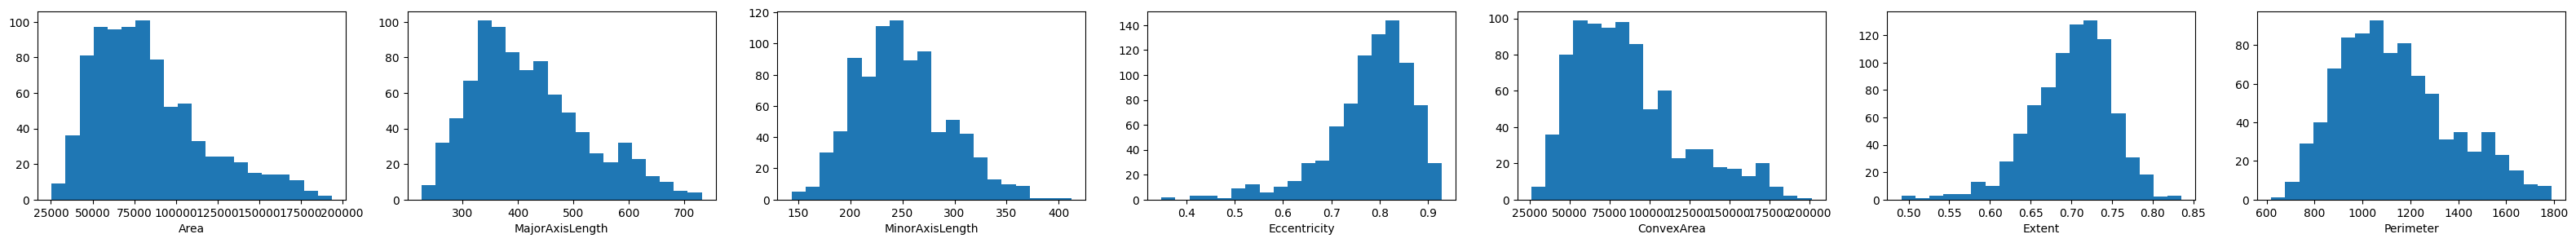

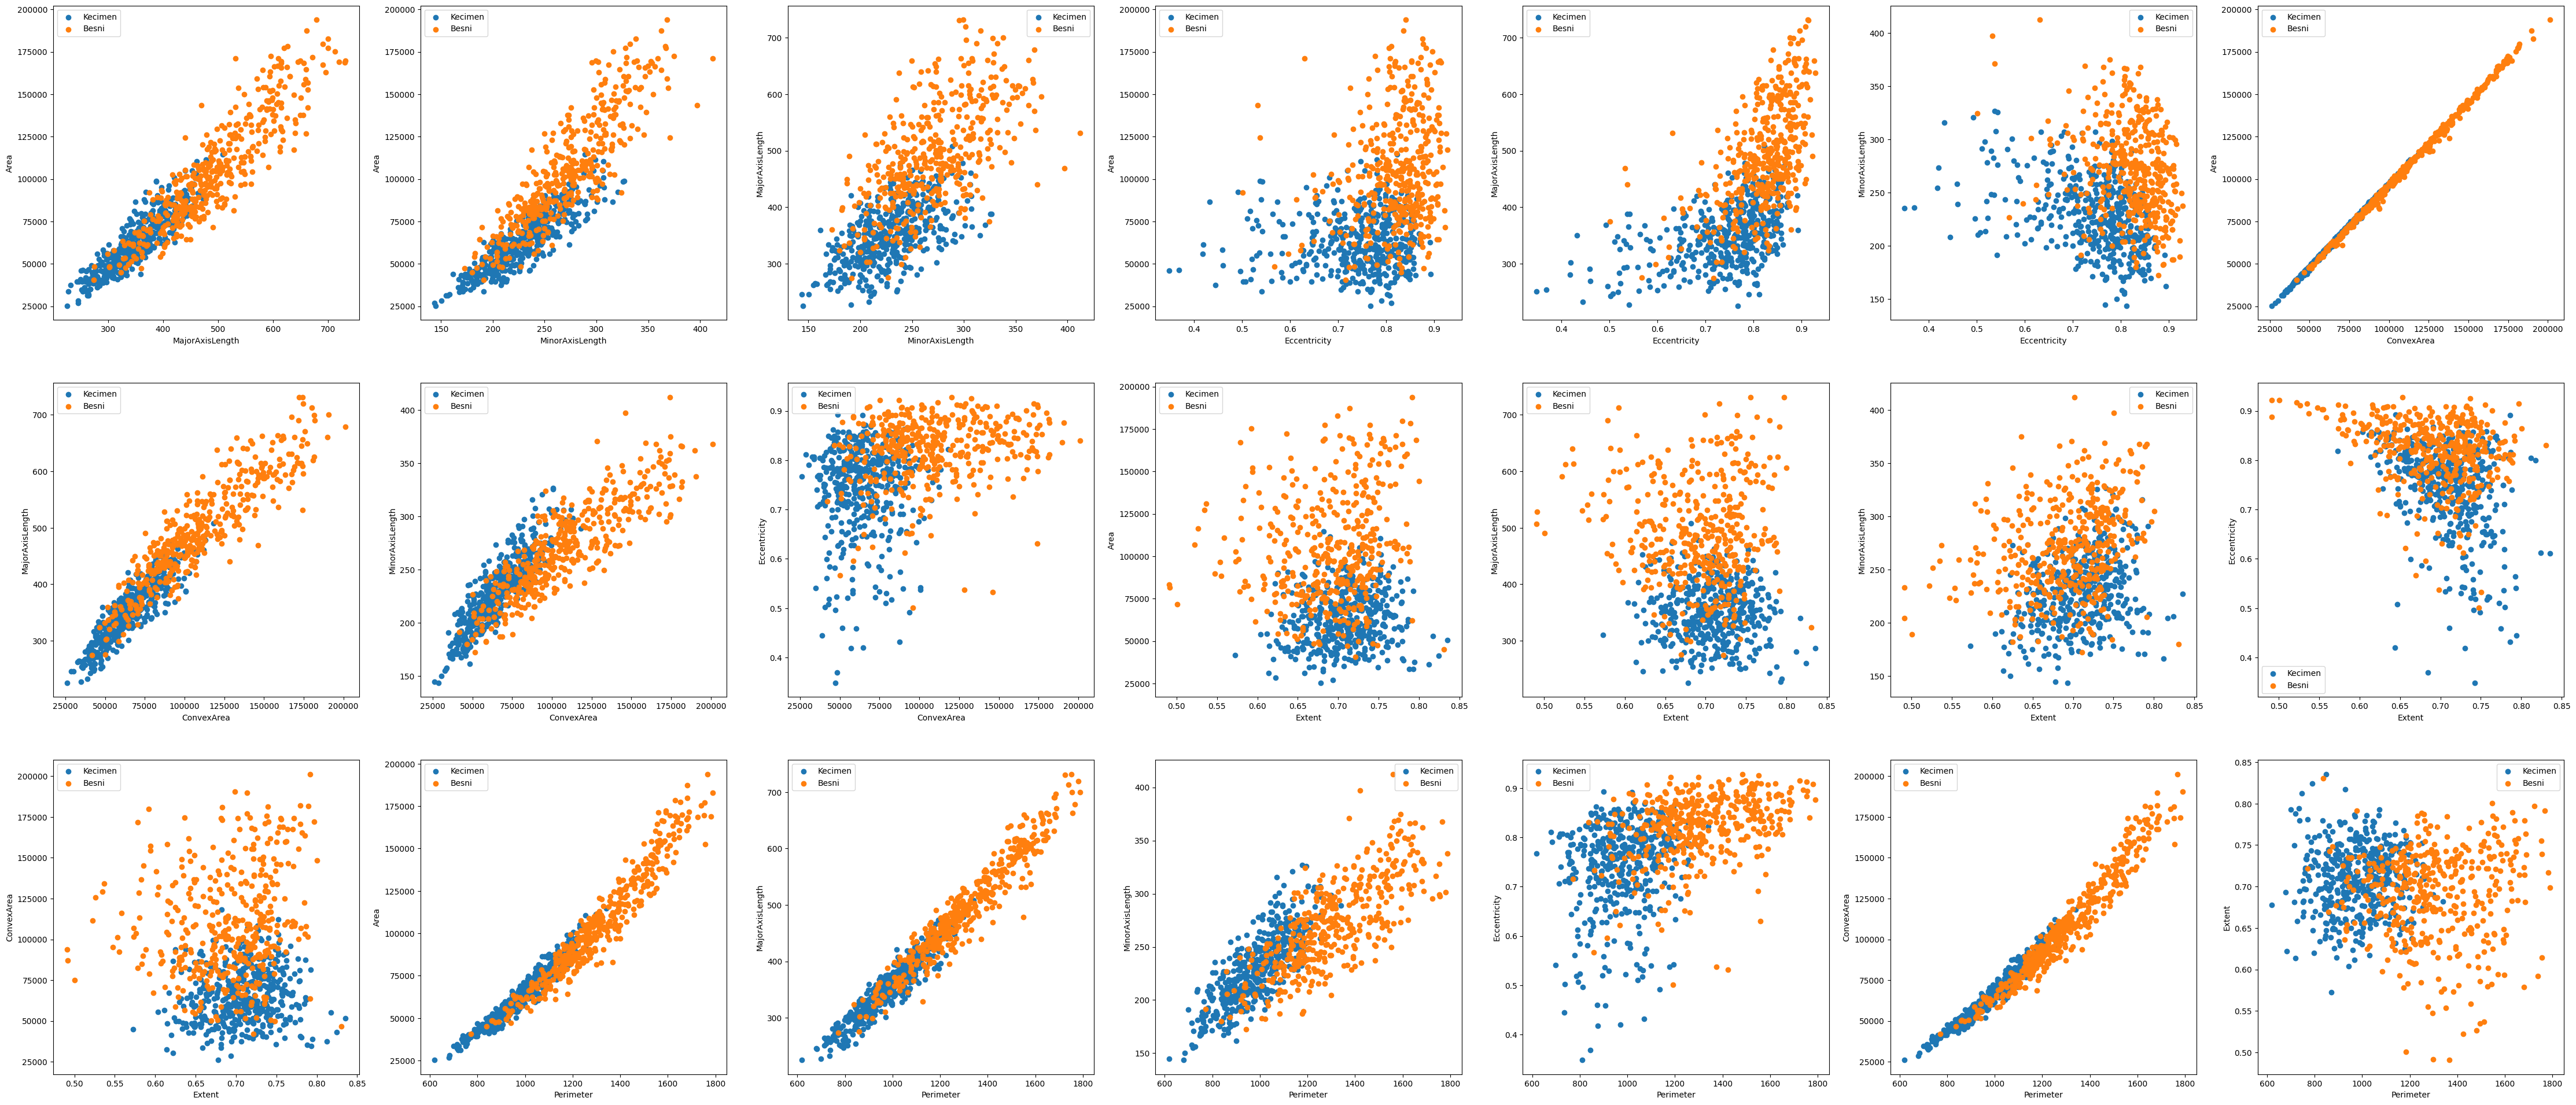

<Figure size 1000x1000 with 0 Axes>

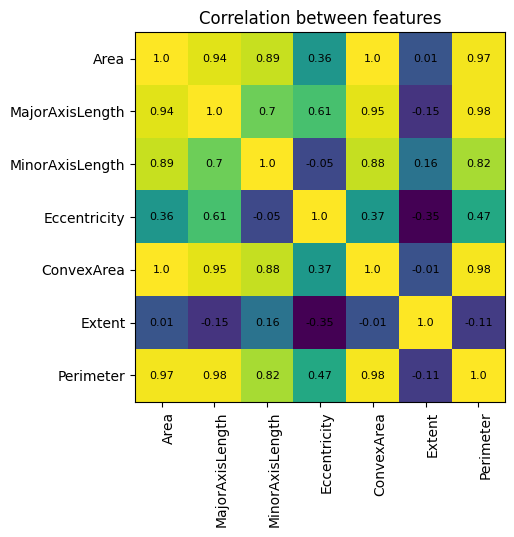

In [24]:
hist_pair_heat(X, X_header, y)

## data pre-processing

Standardize X using StandardScaler

In [25]:
scalar = StandardScaler()
scalar.fit(X.astype(float))
standardized_X = scalar.transform(X)

# Display basic statistics of standardized_X
describe_matrix(standardized_X)

Column		Mean		std		Min		25%		Median		75%		Max		dtype			Null_counts	Outlier_counts
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0         	0.00      	1.00      	-1.76     	-0.75     	-0.19     	0.54      	3.35      	<class 'float'>		0         	25        
1         	-0.00     	1.00      	-1.91     	-0.75     	-0.17     	0.60      	3.06      	<class 'float'>		0         	9         
2         	0.00      	1.00      	-2.42     	-0.72     	-0.09     	0.60      	3.71      	<class 'float'>		0         	9         
3         	0.00      	1.00      	-4.79     	-0.44     	0.20      	0.68      	1.65      	<class 'float'>		0         	42        
4         	0.00      	1.00      	-1.78     	-0.77     	-0.19     	0.56      	3.39      	<class 'float'>		0         	18        
5         	0.00      	1.00      	-4.23     	-0.59     	0.12      	0.68      	2.74      	<cla

#### Encoding Categorical variables

Encode y using LabelEncoder

In [26]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
encoded_y[-5:]

"Kecimen" is encoded as 0
"Besni" is encoded as 1


[1, 1, 1, 1, 1]

#### Split the data into training and testing sets

In [27]:
def TrainTestSplit(X, y, train_ratio, seed=seed):
    """
    Splits the data into train and test sets based on the train ratio.
    """
    y = np.array(y)
    # set the random seed for reproducibility
    np.random.seed(seed)

    # shuffle the indices of the data array
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    # define the ratio of train to test data
    train_ratio = train_ratio

    # split the data array into train and test sets based on the ratio
    split_ids = int(train_ratio * X.shape[0])
    train_ids, test_ids = indices[:split_ids], indices[split_ids:]
    # split the data and target arrays into train and test sets
    X_train, y_train = X[train_ids], y[train_ids]
    X_test, y_test = X[test_ids], y[test_ids]
    
    return (X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = TrainTestSplit(standardized_X, encoded_y, train_ratio=0.8)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

## Model training

In [28]:
# Creating MLPClassifier model with 7 input nodes with 1 hidden layer of size 10 and 1 output node
model = MLPClassifierNP(7, [10], 1, seed=seed)

# Training the model and collecting metrics at each epoch into history variable
history = model.fit(X=X_train, y=y_train,learning_rate=learning_rate, epochs=epochs)

# Model Predictions
predictions = model.predict(X_test)



Create and plot graphs that display the training loss and accuracy as a function of epoch.

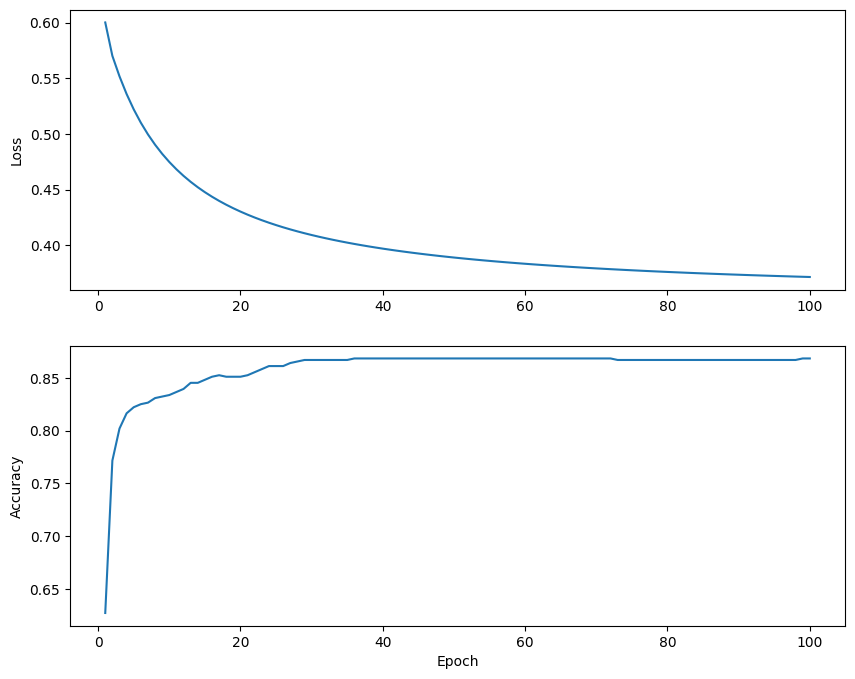

Lowest loss = 0.3715 at epoch 100 and loss at final epoch is 0.3715
Highest accuracy = 0.8685 at epoch 36 and accuracy at final epoch is 0.8685


In [29]:
def history_plot(history):
    fig, ax = plt.subplots(2, figsize=(10, 8))
    ax[0].plot(range(1, len(history[0])+1), history[0])
    ax[0].set_ylabel('Loss')
    ax[1].plot(range(1, len(history[1])+1), history[1])
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel('Accuracy')
    plt.show()
    print(f'Lowest loss = {np.min(np.array(history[0])):0.4f} at epoch {np.argmin(np.array(history[0]))+1} and loss at final epoch is {history[0][-1]:0.4f}')
    print(f'Highest accuracy = {np.max(np.array(history[1])):0.4f} at epoch {np.argmax(np.array(history[1]))+1} and accuracy at final epoch is {history[1][-1]:0.4f}')

history_plot(history)

## model evaluation

Cross Validation : Obtaining a More Accurate and Reliable Estimate of Model Performance using K-fold cross validation.

In [30]:
avg_acc, scores = model.k_fold_cross_val_score(X_train, y_train, k=10, learning_rate=learning_rate, epochs=epochs, seed=seed)
print(f"Accuracies for each fold = {scores:}")
print(f"Average accuracy of the model = {avg_acc}")

Accuracies for each fold = [0.8116, 0.8696, 0.7971, 0.9275, 0.7536, 0.8551, 0.8551, 0.8696, 0.8116, 0.8732]
Average accuracy of the model = 0.8424


In [31]:
def metrics(y_test, predictions):
    labels = np.unique(y_test)
    # Initialize the confusion matrix
    confusion_matrix = np.zeros((len(labels), len(labels)))

    # Populate the confusion matrix
    for i in range(len(labels)):
        for j in range(len(labels)):
            confusion_matrix[i, j] = np.sum((y_test == labels[i]) & (predictions == labels[j]))
        print(f'{"Besni" if labels[i] else "kesimen"}_counts = {np.sum((y_test == labels[i]))}')   

    # Print the confusion matrix
    print(f'{"-"*50}')
    print(f'\t\tconfusion matrix')
    print(f'{"-"*50}')
    print(f'\t\tTrue_Kecimen\tTrue_Besni')
    print(f'Pred_Kecimen\t{confusion_matrix[0, 0]:5.0f}\t\t{confusion_matrix[0, 1]:5.0f}')
    print(f'Pred_Besni\t{confusion_matrix[1, 0]:5.0f}\t\t{confusion_matrix[1, 1]:5.0f}')
    print(f'{"-"*50}')
    # Print different metrics
    accuracy = np.mean(y_test == predictions)
    precision = get_precision(y_test, predictions)
    recall = get_recall(y_test, predictions)
    f1_score = get_f1_score(y_test, predictions)
    print(f'accuracy\t = {accuracy:10.3f}\nprecision\t = {precision:10.3f}\nrecall\t\t = {recall:10.3f}\nf1_score\t = {f1_score:10.3f}')
    print(f'NOTE : Precision, Recall, f1_score are calculated by taking besni as positive class')

metrics(y_test, predictions)

kesimen_counts = 86
Besni_counts = 87
--------------------------------------------------
		confusion matrix
--------------------------------------------------
		True_Kecimen	True_Besni
Pred_Kecimen	   78		    8
Pred_Besni	   14		   73
--------------------------------------------------
accuracy	 =      0.873
precision	 =      0.901
recall		 =      0.839
f1_score	 =      0.869
NOTE : Precision, Recall, f1_score are calculated by taking besni as positive class


## Report

#### Overview

The purpose of this analysis is to classify whether a given measurements belongs to the Kecimen or Besni category using machine learning techniques. The dataset consists of 900 samples, where 450 are from Kecimen category and the other 450 are from Besni category, where each sample contains 7 input features and 1 label.

#### Data exploration

During data exploration, various metrics were calculated to gain insights into the characteristics of the dataset. Outliers were identified, and it was observed that certain features displayed a high degree of correlation. Since MLP classifiers are not adversely affected by outliers, these features were retained for further analysis.

#### Data preparation

To prepare the dataset for training the MLP model, the features were scaled using StandardScaler during the preprocessing step. This was done to standardize the scale of all features with mean 0 and standard deviation of 1, which is crucial to improve the performance and stability of machine learning models.

#### Model Architecture

The MLP model was implemented using MLPClassifierNP. The model had 7 input nodes, 1 hidden layer of size 10, and 1 output node. The activation function used for the hidden layer and output layer was the sigmoid function. The model was trained using a learning rate of 0.005 and 100 epochs.

#### Model Performance

The performance of the model was evaluated using various metrics, including accuracy, precision, recall, and F1-score. The confusion matrix for the model showed that the model was able to correctly identify most of the samples, with only a small number of misclassifications. A k-fold cross-validation was conducted to evaluate the model's performance more comprehensively. The accuracy of the model was 0.873, indicating that the model was able to classify 87.3% of the samples correctly. The precision was 0.901, indicating that when the model predicted that a sample belonged to Kecimen, it was correct 90.1% of the time. The recall was 0.839, indicating that the model correctly identified 83.9% of the Kecimen samples. The F1-score was 0.869, which is a weighted average of the precision and recall, indicating that the model performed well overall.

#### Conclusion

In conclusion, the MLP model trained on the Raisin dataset was able to classify samples into Kecimen and Besni with a high degree of accuracy, precision, and recall. The model can be used to classify new samples into Kecimen or Besni based on their features.
